*Note: If you are reading this in the GitHub repository, it will be rendered as static HTML. If you wish to interact with the jupyter notebook, you will need to download the [ .ipynb ] and the [ Peak3.wav ] example files.* 

Jupyter Notebook Tutorial: [Jupyter Notebook Tutorial](
https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406581035&utm_loc_interest_ms=&utm_loc_physical_ms=9021718&gclid=CjwKCAiAxMLvBRBNEiwAKhr-nM_LEcEwWopPXRs33FJrdjc5necT1LPHYycrJAfQu7cS4XAF37BxkxoCjlQQAvD_BwE
)

# `calc_shift()`

The `calc_shift()` method is used to edit and calculate the number of samples shifted and panned for each audio event. This method does not return anything. This method populates a list, called `audio_events`, within the class that later will be used to reconstruct the signal. Though this method only requires that you pass in as arguements the original signal, and the signals envelope it is encouraged, to achieve best results, to experiment with the other parameters available. 

 Parameter | Default Value  
-----------|---------------
`atkThresh`|0.03
`relThresh`|0.004
`gConst` | 4
`panRatio` | 5
`panThresh` | 50
`magnitudeScale` | 'RMS'

### `atkThresh` & `relThresh`

At what level does the alorithm start detecting an audio event and when do you consider the audio event to be over. Generally the `atkThresh` should be larger than the `relThresh` though there is nothing restricting other values.

If you are unsure where to set the thresholds you can plot the envelope over the original signal and use that to inform your decision. 

The example below also illustrates the three different envelope detection methods that you can use. They all have pros and cons but `get_env_peak()` is the primary one used in all the examples. 


Loaded Peak3.wav | Sample Rate : 44100 | Channels : mono | Length : 1.25s


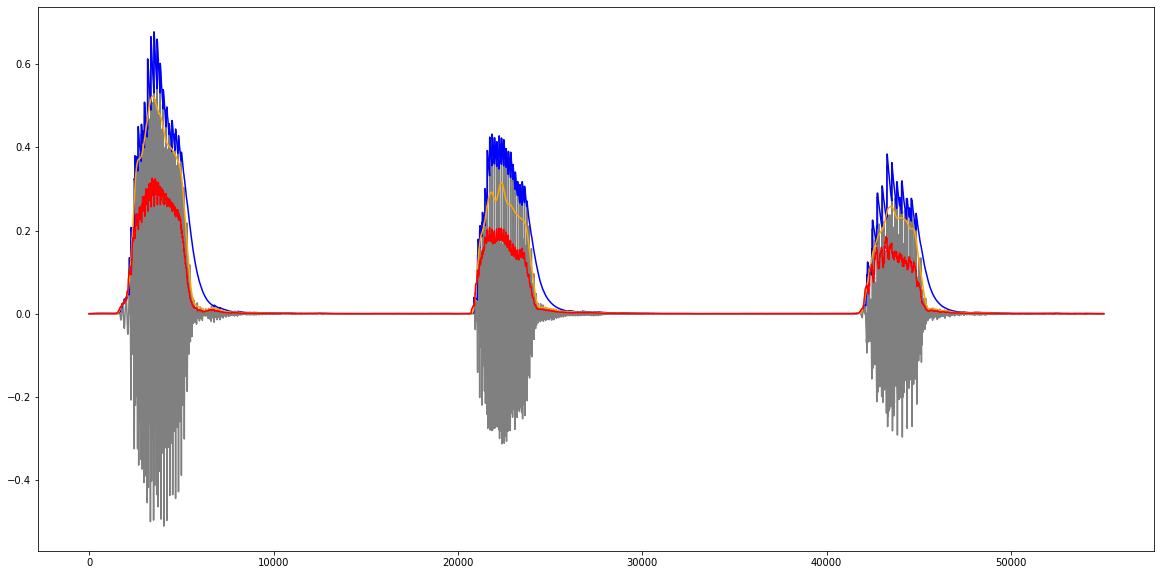

In [3]:
import pyAudGrav
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

audio_file = "Peak3.wav"

io = pyAudGrav.AudioIO(audio_file) 
analyze = pyAudGrav.AudioAnalysis(io.data, io.sample_rate)

env1 = analyze.get_env_rms(analyze.data, 150)
env2 = analyze.get_env_peak(analyze.data)
env3 = analyze.get_env_peak2(analyze.data, 0.01)


plt.figure(figsize=(20,10))

plt.plot(analyze.data, 'grey')

plt.plot(env3, 'blue')
plt.plot(env2, 'orange')
plt.plot(env1, 'red')

plt.show()


### `gConst`

In the equation listed below...

$F = G \frac{m_1 \cdot m_2 }{r^2}$

`gConst` changes the $G$ coefficient. In practice this is used to change how drastic the shifting will be in the reconstructed signal. For subtle shifting use a smaller `gConst` and vice versa. A couple things to note. There is nothing restricting the calculated number of samples shifted from being larger than the original distance between two audio events. In the event that an audio event is shifted out of bounds of the original audio file, the reconstructed array will resize accordingly. When reading in files and exporting files `pyAudGrav` will print some basic information. When writing the reconstructed signal to a new audio file, if the *length* is larger than the original signal, it is because some audio events have been shifted out of bounds and the new signal has had to allocate more space to compensate.    

Loaded Peak3.wav | Sample Rate : 44100 | Channels : mono | Length : 1.25s
Reconstructing MONO signal...


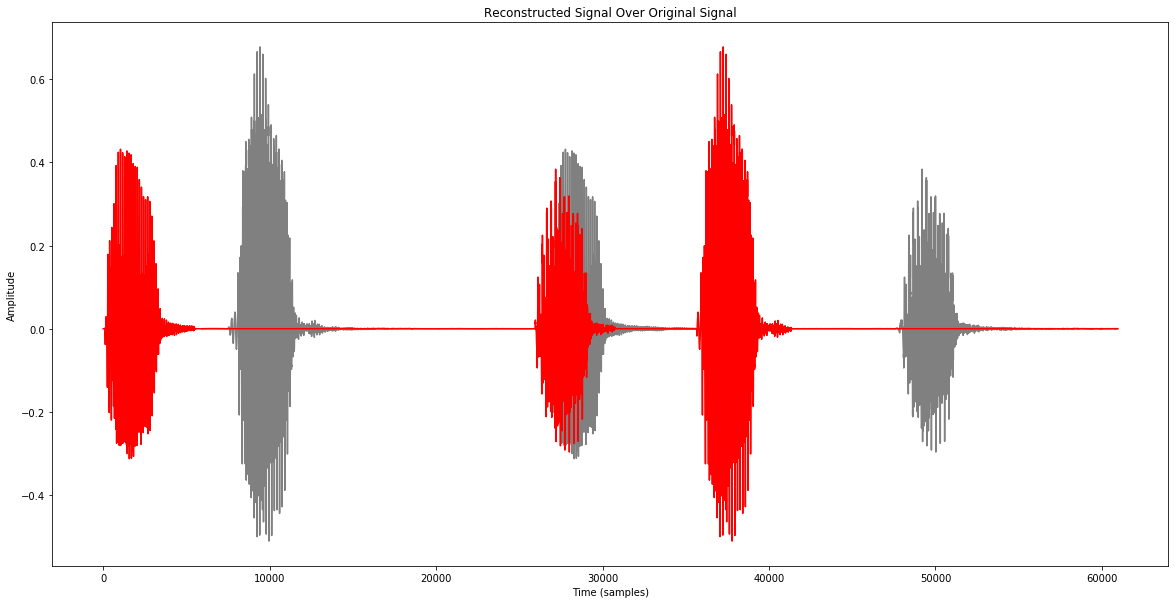

In [6]:
audio_file = "Peak3.wav"

io = pyAudGrav.AudioIO(audio_file) 
analyze = pyAudGrav.AudioAnalysis(io.data, io.sample_rate)

env = analyze.get_env_peak(analyze.data)

analyze.calc_shift(analyze.data, env, gConst=12) # <-- Try Experimenting

rec = pyAudGrav.AudioReconstruct(len(analyze.data), analyze.audio_events)

r_mono = rec.reconstruct_mono()

plt.figure(figsize=(20,10))

plt.title("Reconstructed Signal Over Original Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.plot([i + rec.correction for i in range(len(analyze.data))],
         [item for item in analyze.data],
         'grey')
plt.plot(r_mono, 'r')

plt.show()

### `panRatio` & `panThresh`

The panning values are derived from the number of samples shifted for each audio event, normalized to a range of -100 to 100 (hard pan left and hard pan right). This means that event shifted backwards in the time (left on the timeline) will be panned left and events shifted forward in time will (right on the timeline) be panned right. 

Though changing the `gConst` value will cause an audible difference in the reconstructed signal, the panning values will be the same everytime.
The `panRatio` and `panThresh` arguements are meant to affect how dispersed the events are over the stereo spectrum. 

These values work very similarly to how a normal dynamic range compressor works. Any values above the threshold will be reduced according to the ratio. A pan value of 90, with a threshold of 60 and a ratio of 3 will be reduced to 70. Note that after this compression has occured the pan values will be normalized again to ensure wide stereo separation for the events that exhibit the most extreme panning. 


Loaded Peak3.wav | Sample Rate : 44100 | Channels : mono | Length : 1.25s
Reconstructing MONO signal...


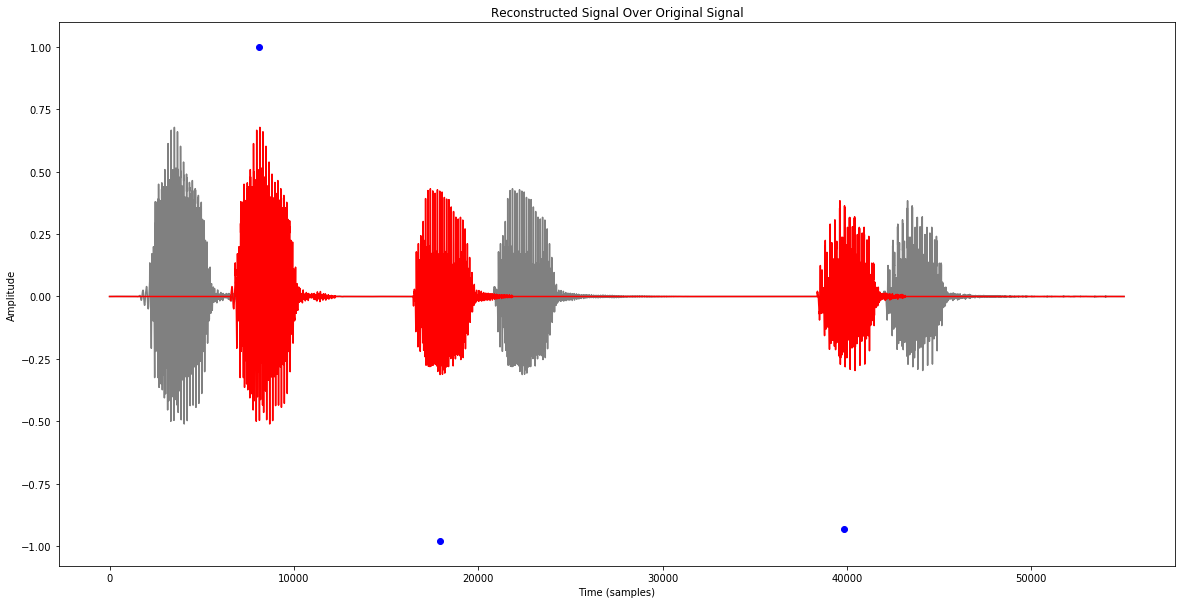

In [13]:
audio_file = "Peak3.wav"

io = pyAudGrav.AudioIO(audio_file) 
analyze = pyAudGrav.AudioAnalysis(io.data, io.sample_rate)

env = analyze.get_env_peak(analyze.data)

analyze.calc_shift(analyze.data, env, 
                   gConst=2,
                   panRatio=4,
                   panThresh=50) # <-- Try Experimenting

rec = pyAudGrav.AudioReconstruct(len(analyze.data), analyze.audio_events)

r_mono = rec.reconstruct_mono()

plt.figure(figsize=(20,10))

plt.title("Reconstructed Signal Over Original Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.plot([i + rec.correction for i in range(len(analyze.data))],
         [item for item in analyze.data],
         'grey')
plt.plot(r_mono, 'r')
plt.plot([obj.peakIdx + obj.offset + rec.correction for obj in analyze.audio_events], 
         [obj.panOffset * 0.01 for obj in analyze.audio_events], 
         'ob')
plt.show()


*In this example the blue dots indicate the panning location. Negative values are panned left and postive values are panned right.* 

### `magnitudeScale`

By default, we use `'RMS'` to calculate the magnitude of each audio event. pyAudGrav does offer the ability to use `'LUFS'` (Loudness Units Full Scale) instead. RMS is the recommended magnitude scale.  

# `loop_gravity()`

pyAudGrav provides a method that allows the user to loop over the same set of data multiple times before writing out the file. This method offers all of the same arguements as `calc_shift()` with a couple extra ones. This method requires that you pass in the original data and the original data's envelope similar to `calc_shift()`. The difference is that this method also handles the reconstruction of the signal and will return the reconstructed STEREO signal (currently `loop_gravity()` only supports a STEREO return type). 

 Parameter | Default Value  
-----------|---------------
`atkThresh`|0.03
`relThresh`|0.004
`numLoops` | 4
`gConst` | 4
`panRatio` | 5
`panThresh` | 50
`magnitudeScale` | 'RMS'
`plot` | False

### `numLoops`

Simply indicate how many times you want to iterate over the same set of data. Minimum of 2.

### `plot`

`plot` is a boolean. By setting plot to `True` you indicate that you want each loop iteration to be plotted. This is helpful for visualizing the gravity shifting over time, but may be cumbersom when a large number of loops is desired. **With each plot, the user will need to exit out of the pyplot to advance to the next loop**. 

*To view the example code for `loop_gravity()` please refer to the README.md*

# Full Example With Player

In [15]:
audio_file = "Peak3.wav"

io = pyAudGrav.AudioIO(audio_file)  # <-- Create an IO object
analyze = pyAudGrav.AudioAnalysis(io.data, io.sample_rate)

env = analyze.get_env_peak(analyze.data)

analyze.calc_shift(analyze.data, env, 
                   atkThresh=0.03,
                   relThresh=0.004,
                   gConst=2,
                   panRatio=4,
                   panThresh=50) # <-- Try Experimenting

# Reconstruction object 
rec = pyAudGrav.AudioReconstruct(len(analyze.data), analyze.audio_events)

r_stereo = rec.reconstruct_stereo()

io.writeWav("Peak3_jupyter_example.wav", r_stereo)

Loaded Peak3.wav | Sample Rate : 44100 | Channels : mono | Length : 1.25s
Reconstructing STEREO signal...
Writing Peak3_jupyter_example.wav | Sample Rate : 44100 | Channels : stereo | Length : 1.25s


In [18]:
# Player Doesn't Work in GitHub

ipd.Audio("Peak3_jupyter_example.wav") 